# Disseration Experiment 3b
# Viz Explore and Build Performance Model (Generic Code) October Two¶
Ciaran Finnegan October 2023

In [9]:
# Import libs
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import shap
import random

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.spatial import distance

from sklearn.preprocessing import LabelEncoder
import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Data Visualisation and Exploration

## Import Data

In [2]:
ds_file_to_load = 'credit_default_data.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

In [3]:
def styled_dataframe(df):
    styles = {
        'selector': 'table',
        'props': [('background-color', '#f4f4f4'),
                  ('color', '#000000'),
                  ('border-color', '#e0e0e0'),
                  ('border', '1px solid #e0e0e0'),
                  ('font-family', 'Arial, sans-serif'),
                  ('width', '100%')]
    }
    
    # Apply the styles to the dataframe
    styled_df = (df.style.set_table_styles([styles])
                 .set_properties(subset=df.columns, **{'min-width': '5000px', 'text-align': 'center'})
                 .format(None, na_rep='NA'))
    
    # Convert styled dataframe to HTML and wrap in a div container for scrolling
    styled_html = f'<div style="width:100%; overflow-x:auto;">{styled_df.render()}</div>'
    
    return display(HTML(styled_html))

# To check the function (using a sample dataframe)
sample_df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [5, 6, 7, 8, 9],
    'C': [1, 2, 3, 4, 5],
    'D': [5, 6, 7, 8, 9],
    'E': [1, 2, 3, 4, 5]
})
styled_dataframe(sample_df)

,A,B,C,D,E
0,1,5,1,5,1
1,2,6,2,6,2
2,3,7,3,7,3
3,4,8,4,8,4
4,5,9,5,9,5


### Dataset Structure

In [4]:
# Display the first few rows of the dataset to understand its structure
#df.head()
#print(df.head().to_string())
styled_dataframe(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# Display the dataframe as plain text to bypass any CSS/HTML styles
print(df.head().to_string())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
0      20000    2          2         1   24      2      2     -1     -1     -2     -2       3913       3102        689          0          0          0         0       689         0         0         0         0        1
1     120000    2          2         2   26     -1      2      0      0      0      2       2682       1725       2682       3272       3455       3261         0      1000      1000      1000         0      2000        1
2      90000    2          2         2   34      0      0      0      0      0      0      29239      14027      13559      14331      14948      15549      1518      1500      1000      1000      1000      5000        0
3      50000    2          2         1   37      0      0      0      0      0      0      46990      48233      492

### Generate Visualizations

In [7]:
# Set up the target and features to be visualised

sTarget_feature = 'default'
sFeature_analysis_1 = 'LIMIT_BAL'
sFeature_analysis_2 = 'AGE'
sFeature_analysis_3 = 'SEX'
sFeature3_ticklabel1 = 'Male'
sFeature3_ticklabel2 = 'Female'

In [8]:
# Generate Visualizations to better understand the data distribution and relationships between features.

#### Bar and Box Plot Visualisations

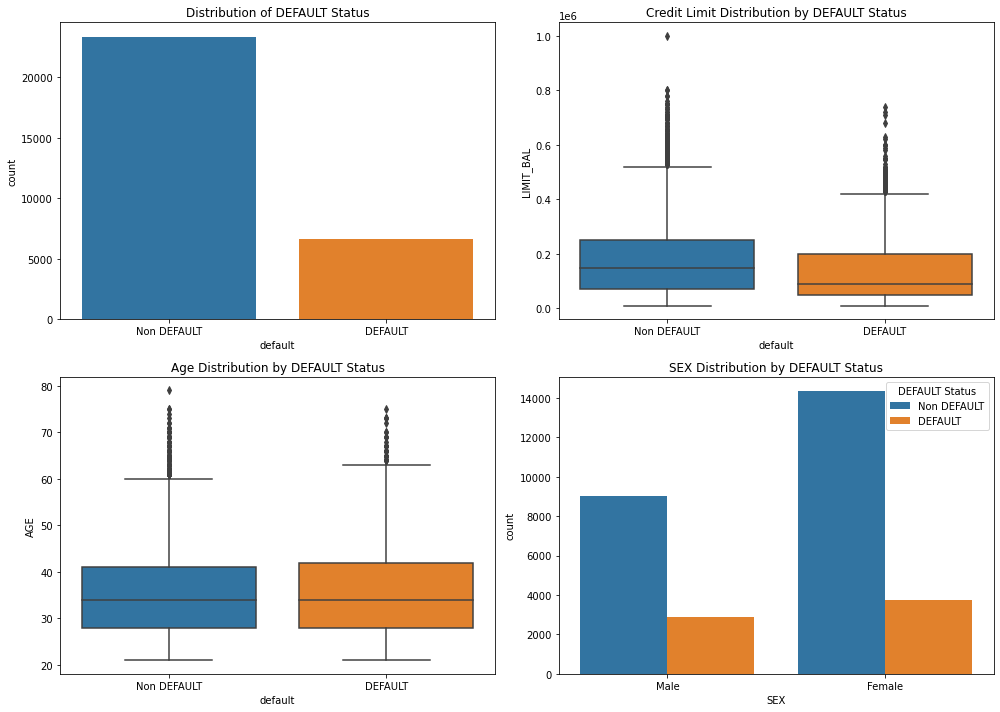

In [10]:
# Set up the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot distribution of the dataset target variable
sns.countplot(data=df, x=sTarget_feature, ax=ax[0, 0])
sPlot_title1 = 'Distribution of ' + sTarget_feature.upper() + ' Status'
ax[0, 0].set_title(sPlot_title1)
ax[0, 0].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature one> based on target variable status
sns.boxplot(data=df, x=sTarget_feature, y=sFeature_analysis_1, ax=ax[0, 1])
sPlot_title2 = 'Credit Limit Distribution by ' + sTarget_feature.upper() + ' Status'
ax[0, 1].set_title(sPlot_title2)
ax[0, 1].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature two>  based on target variable status
sns.boxplot(data=df, x=sTarget_feature, y=sFeature_analysis_2, ax=ax[1, 0])
sPlot_title3 = 'Age Distribution by ' + sTarget_feature.upper() + ' Status'
ax[1, 0].set_title(sPlot_title3)
ax[1, 0].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature three> based on target variable status
sns.countplot(data=df, x=sFeature_analysis_3, hue=sTarget_feature, ax=ax[1, 1])
sPlot_title4 = sFeature_analysis_3.upper() + ' Distribution by ' + sTarget_feature.upper() + ' Status'
ax[1, 1].set_title(sPlot_title4)
ax[1, 1].set_xticklabels([sFeature3_ticklabel1, sFeature3_ticklabel2])
ax[1, 1].legend(title=sTarget_feature.upper() + ' Status', labels=['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

plt.tight_layout()
plt.show()

#### Heatmap Visualisation

In [11]:
# Would need feature reduction to work effectively - or some other filtering

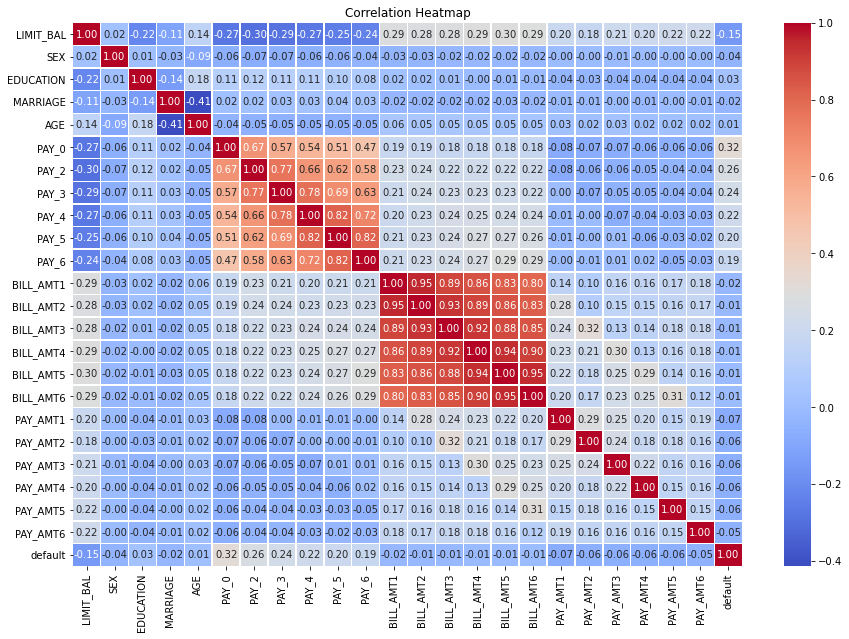

In [12]:
# Plotting correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

#### Distributions

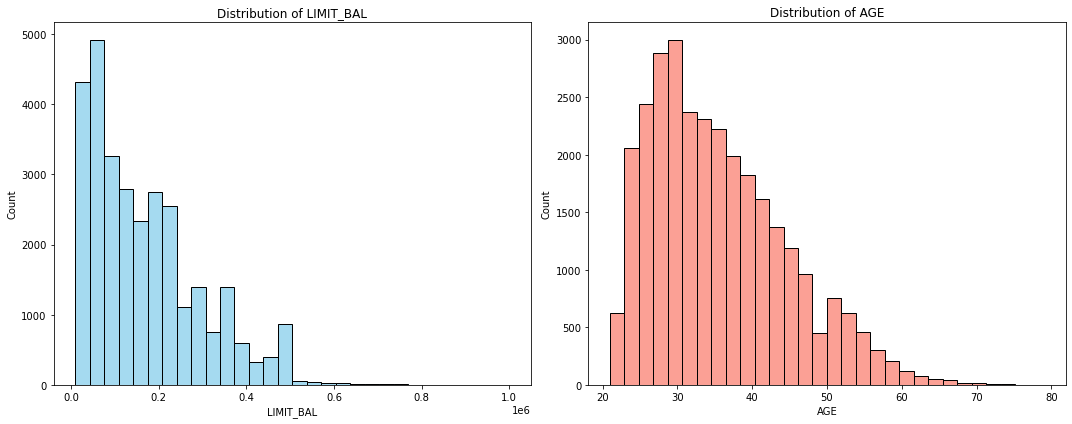

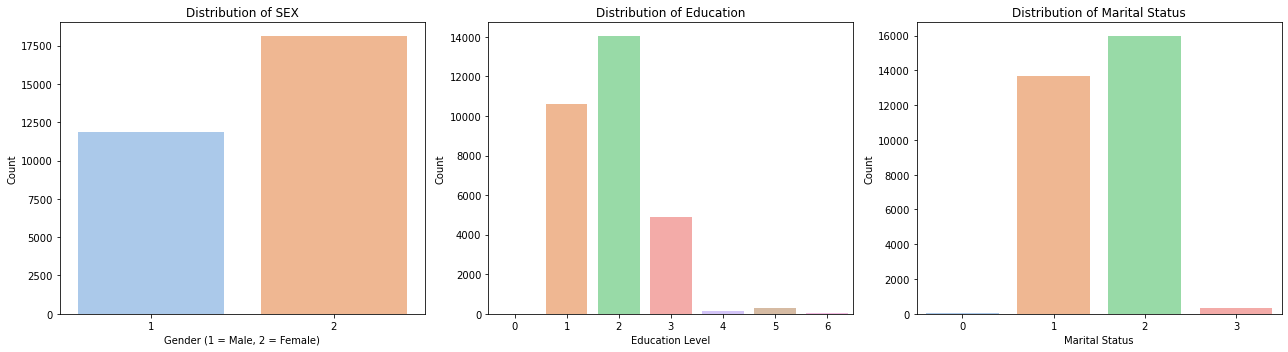

In [13]:
# Plotting distributions for continuous features
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df[sFeature_analysis_1], bins=30, ax=ax[0], color="skyblue")
ax[0].set_title("Distribution of "+sFeature_analysis_1.upper())
ax[0].set_xlabel(sFeature_analysis_1.upper())
#ax[0].set_xlabel("Credit Limit")
ax[0].set_ylabel("Count")

sns.histplot(df[sFeature_analysis_2], bins=30, ax=ax[1], color="salmon")
ax[1].set_title("Distribution of "+ sFeature_analysis_2.upper())
ax[1].set_xlabel(sFeature_analysis_2.upper())
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Plotting distributions for categorical features
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x=sFeature_analysis_3, ax=ax[0], palette="pastel")
ax[0].set_title("Distribution of " + sFeature_analysis_3.upper())
ax[0].set_xlabel("Gender (1 = Male, 2 = Female)")
ax[0].set_ylabel("Count")

sns.countplot(data=df, x="EDUCATION", ax=ax[1], palette="pastel")
ax[1].set_title("Distribution of Education")
ax[1].set_xlabel("Education Level")
ax[1].set_ylabel("Count")

sns.countplot(data=df, x="MARRIAGE", ax=ax[2], palette="pastel")
ax[2].set_title("Distribution of Marital Status")
ax[2].set_xlabel("Marital Status")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Feature Engineering

## Check for Missing Data

In [14]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

# Print the columns with more than 75% missing values
print("Columns with more than 75% missing values:", missing_columns)

# Drop columns with missing values greater than the threshold
df = df.drop(columns=missing_columns)

# Save or continue processing with columns removed that had high volumes of missing data

Columns with more than 75% missing values: Index([], dtype='object')


In [15]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Categorical Data 

In [16]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [17]:
# Adjust cat columns to range from 0
# df[cat_cols] = df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

In [18]:
# One-hot encode categorical variables
#df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded = pd.get_dummies(df, columns=cat_cols)

In [19]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [20]:
# Display the first few rows of the dataset to understand its structure
df_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


In [21]:
# display all columns
pd.set_option('display.max_columns', None)
print(df_encoded)

       LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0          20000   24       3913       3102        689          0          0   
1         120000   26       2682       1725       2682       3272       3455   
2          90000   34      29239      14027      13559      14331      14948   
3          50000   37      46990      48233      49291      28314      28959   
4          50000   57       8617       5670      35835      20940      19146   
...          ...  ...        ...        ...        ...        ...        ...   
29995     220000   39     188948     192815     208365      88004      31237   
29996     150000   43       1683       1828       3502       8979       5190   
29997      30000   37       3565       3356       2758      20878      20582   
29998      80000   41      -1645      78379      76304      52774      11855   
29999      50000   46      47929      48905      49764      36535      32428   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  P

# Build Model

## Split Features + Target

In [22]:
# Split data into features and target
X = df_encoded.drop('default', axis=1)
y = df_encoded['default']

## Split Data into Test/Training Datasets

In [23]:
# Split into inference and training splits
X_train, X_inf, y_train, y_inf = train_test_split(X, y, test_size=0.30, random_state=42)

In [24]:
# Split Train into train test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [25]:
X_train = X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
X_inf = X_inf.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)
y_inf = y_inf.reset_index(drop=True)

### Basic Additional Data Exploration (Training Data)

In [26]:
# Train model Stats

print("Number of Features:", X_train.shape[1])
print("Number Continuous Features:", X_train.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train.shape[0])
print("Number Positive Train Examples:", (y_train == 1).sum())
print("Number Negative Train Examples:", (y_train == 0).sum())

Number of Features: 91
Number Continuous Features: 82
Number Categorical Features: 9
Number Train Examples: 14700
Number Positive Train Examples: 3292
Number Negative Train Examples: 11408


## Downsample Majority Class

In [27]:
# Separate the majority and minority classes in the training data
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]
y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Under-sample the majority class
X_train_majority_downsampled, y_train_majority_downsampled = resample(
    X_train_majority, 
    y_train_majority,
    replace=False, 
    n_samples=len(y_train_minority), 
    random_state=42
)

# Combine the down-sampled majority class with the minority class
X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
y_train_downsampled = pd.concat([y_train_majority_downsampled, y_train_minority])

## Apply RF Hyperparameters

In [28]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='recall_macro')

grid_search.fit(X_train_downsampled, y_train_downsampled)

# Get the best parameters
best_params = grid_search.best_params_

print(best_params)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.3min finished


{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


## Train Model

In [29]:
# Set Up Random Forest model
# Train the Random Forest classifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params, random_state=42)
#rf_classifier = RandomForestClassifier(random_state=42)
#rf_classifier.fit(X_train, y_train)

In [30]:
# Set up LGBMClassifier model
lgbm_model = lgb.LGBMClassifier()

In [31]:
# Assign model
model = rf_classifier 
#model = lgbm_model 

In [32]:
# Train chosen model
#model.fit(X_train, y_train)
# Retrain the Random Forest classifier on the downsampled data
model.fit(X_train_downsampled, y_train_downsampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=50,
                       random_state=42)

# Evaluate Model

## Predict on Test Data

In [33]:
# Predict on the test data
y_pred = model.predict(X_test)

## Assess Model Peformance

In [34]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

#accuracy, classification_rep, conf_matrix

In [35]:
# Extract metrics directly from the classification_report function in a structured format
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Organize the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC Score', 'Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)', 
               'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)'],
    'Value': [accuracy, roc_auc, 
              report_dict['0']['precision'], report_dict['0']['recall'], report_dict['0']['f1-score'],
              report_dict['1']['precision'], report_dict['1']['recall'], report_dict['1']['f1-score']]
})

# Display the dataframe in a tabular format
display(HTML(metrics_df.to_html(index=False, classes="table table-striped table-bordered")))

Metric,Value
Accuracy,0.755556
ROC AUC Score,0.711251
Precision (Class 0),0.884160
Recall (Class 0),0.790277
F1-Score (Class 0),0.834586
Precision (Class 1),0.459077
Recall (Class 1),0.632225
F1-Score (Class 1),0.531915


# Generate Shap Values

## Test Data dataset

In [36]:
# Initialize the SHAP explainer with the trained model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test dataset
shap_values = explainer.shap_values(X_test)

# Get the SHAP values for class 1 (default)
shap_values_class1 = shap_values[1]

# Compute the mean absolute SHAP value for each feature
mean_shap_values = pd.Series(np.abs(shap_values_class1).mean(axis=0), index=X_test.columns)

# Get the top 20 features based on mean absolute SHAP value
top_20_features = mean_shap_values.sort_values(ascending=False).head(20)

# Display the top 20 features in an aesthetically pleasing tabular format
top_20_features_df = pd.DataFrame({'Feature': top_20_features.index, 'SHAP Value': top_20_features.values})

# Enhanced table styling using HTML and CSS
styles = """
    <style>
        table {
            border-collapse: collapse;
            width: 50%;
            font-family: Arial, sans-serif;
        }
        th {
            background-color: #4CAF50;
            color: white;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        tr:nth-child(even) {
            background-color: #f2f2f2;
        }
        tr:hover {
            background-color: #ddd;
        }
    </style>
"""

display(HTML(styles + top_20_features_df.to_html(index=False)))

Feature,SHAP Value
PAY_0_0,0.039833
PAY_0_2,0.034947
PAY_AMT2,0.021560
PAY_3_2,0.021495
LIMIT_BAL,0.020673
PAY_2_2,0.018512
PAY_2_0,0.017032
PAY_AMT1,0.015704
PAY_AMT4,0.013954
PAY_6_2,0.013179


Breakdown:

Initialization: We use the TreeExplainer from the shap library to initialize an explainer object with 
our trained Random Forest model.

Compute SHAP values: The shap_values method of the explainer is used to compute SHAP values for the test dataset. 
This will give us a matrix where each row corresponds to a sample in the test set and each column represents a feature. 
The values indicate how much each feature contributed to the prediction for each sample.

Mean SHAP values: We take the absolute SHAP values and compute their mean across all samples for each feature. 
This gives us an idea of the overall importance of each feature.

Top 20 features: We then sort the features based on their mean absolute SHAP value and select the top 20.

Display: Finally, we display the top 20 features and their associated SHAP values in an aesthetically pleasing 
tabular format, aligning the text to the left for better readability.

## Single Random Observation

In [38]:
# Select a random observation from the test dataset
random_observation = X_test.sample(1, random_state=42)

# Compute the SHAP values for this observation
shap_values_random_observation = explainer.shap_values(random_observation)

# Get the SHAP values for class 1 (default) for this observation
shap_values_observation_class1 = shap_values_random_observation[1]

# Convert SHAP values to a Series for easier manipulation
shap_values_series = pd.Series(shap_values_observation_class1[0], index=random_observation.columns)

# Sort the features based on absolute SHAP value
sorted_features = shap_values_series.abs().sort_values(ascending=False)

# Display the top 20 features for the random observation in an aesthetically pleasing tabular format
top_20_features_observation = sorted_features.head(20)
top_20_features_df_observation = pd.DataFrame({'Feature': top_20_features_observation.index, 'SHAP Value': top_20_features_observation.values})

# Enhanced table styling using HTML and CSS
styles = """
    <style>
        table {
            border-collapse: collapse;
            width: 50%;
            font-family: Arial, sans-serif;
        }
        th {
            background-color: #4CAF50;
            color: white;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        tr:nth-child(even) {
            background-color: #f2f2f2;
        }
        tr:hover {
            background-color: #ddd;
        }
    </style>
"""

# Display the index (row number) of the selected observation
print(f"Selected Row Number from Test Data: {random_observation.index[0]}")

# Display the SHAP values for the top 20 features of the observation
print("\nTop 20 Features and Their SHAP Values:")
display(HTML(styles + top_20_features_df_observation.to_html(index=False)))

Selected Row Number from Test Data: 1893

Top 20 Features and Their SHAP Values:


Feature,SHAP Value
PAY_3_2,0.063824
PAY_4_2,0.039714
PAY_AMT2,0.028150
PAY_0_2,0.021249
PAY_AMT3,0.021220
PAY_0_0,0.019033
PAY_2_0,0.014367
PAY_2_2,0.013458
BILL_AMT1,0.011858
BILL_AMT2,0.010130


# Prepare Data for Metric Calculations

## Identity

In [39]:
#### Files...

In [40]:
# Ensure reproducibility
np.random.seed(42)

# Filter out instances of class '1'
class_1_indices = X_test[y_test == 1].index

# Randomly select 10 instances from class '1'
selected_class_1_indices = np.random.choice(class_1_indices, 10, replace=False)

# Randomly select 25 instances from the remaining dataset
remaining_indices = X_test.index.difference(class_1_indices)
selected_remaining_indices = np.random.choice(remaining_indices, 25, replace=False)

# Combine the selected indices
selected_indices = np.concatenate([selected_class_1_indices, selected_remaining_indices])

# Extract the selected instances for features
features_df = X_test.loc[selected_indices]

# Generate SHAP values for the selected instances
explainer = shap.TreeExplainer(model)  # Assuming 'model' is the trained Random Forest model
shap_values_selected = explainer.shap_values(features_df)

# If binary classification, we only need the second set of SHAP values
if len(shap_values_selected) == 2:
    shap_values_selected = shap_values_selected[1]

# Convert SHAP values to a dataframe
shap_values_df = pd.DataFrame(shap_values_selected, columns=['SHAP_' + col for col in features_df.columns], index=features_df.index)

# Combine features with SHAP values
combined_df = pd.concat([features_df, shap_values_df], axis=1)

In [41]:
# Save the combined dataframe to 'selected_records.csv'
combined_df.to_csv('selected_records.csv', index=False)

In [42]:
# Save the combined dataframe to 'selected_records.csv'
features_df.to_csv('features.csv', index=False)

In [43]:
# Save the combined dataframe to 'selected_records.csv'
shap_values_df.to_csv('shap_values.csv', index=False)

In [44]:
print(features_df.head())

      LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
3912      20000   22      17676      18833      19002      18982      13762   
1145     120000   29      87376      85135      86024      91380      93263   
786      500000   55     613860     512526     334227     145482     125936   
3420      50000   27      12250      11761      12476      11979      12880   
218       30000   25       8341      10039      11560      16611      18179   

      BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
3912          0      1451      1400       380         0         0         0   
1145      95079         0      3200      6800      3500      3500         0   
786       91382     37300     11000      4500      4000      4000    100000   
3420      12531         0      1200         0      1100         0      1200   
218       19712      2000      2000      5611      2000      2000      1500   

      SEX_1  SEX_2  EDUCATION_0  EDUCATION_1  EDUC

In [45]:
print(shap_values_df.head())

      SHAP_LIMIT_BAL  SHAP_AGE  SHAP_BILL_AMT1  SHAP_BILL_AMT2  \
3912        0.051437 -0.000264       -0.004038        0.008976   
1145       -0.003032 -0.001338        0.008432        0.002844   
786        -0.021389  0.005818        0.023021        0.021749   
3420        0.016458 -0.002706        0.000671        0.003311   
218         0.045089  0.003445        0.005336        0.002841   

      SHAP_BILL_AMT3  SHAP_BILL_AMT4  SHAP_BILL_AMT5  SHAP_BILL_AMT6  \
3912        0.004847        0.004826       -0.005339       -0.011475   
1145        0.011110        0.004520        0.004001        0.008280   
786         0.020734        0.008921        0.006883        0.000407   
3420        0.005382       -0.004122       -0.005374       -0.000654   
218         0.000028        0.000161        0.003209       -0.000436   

      SHAP_PAY_AMT1  SHAP_PAY_AMT2  SHAP_PAY_AMT3  SHAP_PAY_AMT4  \
3912      -0.003268       0.019073       0.009970       0.016475   
1145       0.033107      -0.005991

#### Identity Function

In [52]:
def match_percentage_ident1(features_df, shap_values_df):
    """
    For each instance in the feature dataframe, this function identifies the closest instance 
    based on Euclidean distance. It then does the same for the corresponding SHAP value. 
    The function checks if the closest instances for both features and SHAP values match.
    
    Returns:
        Percentage of instances where the closest feature and SHAP value instances match.
    """

    # Initialize match count to zero
    match_count = 0
    
    # Loop through each instance in the feature dataframe
    for idx, instance in features_df.iterrows():
        # Compute the Euclidean distance between the current instance and all other instances
        feature_distances = features_df.drop(index=idx).apply(lambda row: distance.euclidean(row, instance), axis=1)
        
        # Identify the index of the closest instance
        closest_feature_idx = feature_distances.idxmin()
        
        # Repeat the process for SHAP values
        shap_instance = shap_values_df.loc[idx]
        shap_distances = shap_values_df.drop(index=idx).apply(lambda row: distance.euclidean(row, shap_instance), axis=1)
        closest_shap_idx = shap_distances.idxmin()
        
        # Check if the closest instances for both features and SHAP values match
        if closest_feature_idx == closest_shap_idx:
            match_count += 1
        
        # Print the distances for debugging purposes
        print(f"Instance {idx}:   Current matches: {match_count}")
        print(f"\tClosest feature instance: {closest_feature_idx} (Distance: {feature_distances[closest_feature_idx]:.4f})")
        print(f"\tClosest SHAP instance: {closest_shap_idx} (Distance: {shap_distances[closest_shap_idx]:.4f})")

    # Compute the matching percentage
    percentage = (match_count / len(features_df)) * 100
    print(f"\nPercentage of matches: {percentage:.2f}%   {match_count} Matches of {len(features_df)} Entries")
    
    return percentage

In [53]:
# Test the function
match_percentage_ident1(features_df, shap_values_df)

Instance 3912:   Current matches: 0
	Closest feature instance: 5845 (Distance: 22727.5650)
	Closest SHAP instance: 3423 (Distance: 0.0609)
Instance 1145:   Current matches: 0
	Closest feature instance: 3736 (Distance: 46828.9278)
	Closest SHAP instance: 535 (Distance: 0.0899)
Instance 786:   Current matches: 0
	Closest feature instance: 2564 (Distance: 603985.9064)
	Closest SHAP instance: 2063 (Distance: 0.0773)
Instance 3420:   Current matches: 0
	Closest feature instance: 1767 (Distance: 16367.6663)
	Closest SHAP instance: 785 (Distance: 0.0711)
Instance 218:   Current matches: 0
	Closest feature instance: 785 (Distance: 14634.0527)
	Closest SHAP instance: 5845 (Distance: 0.0286)
Instance 2073:   Current matches: 0
	Closest feature instance: 3423 (Distance: 11440.6896)
	Closest SHAP instance: 3469 (Distance: 0.0221)
Instance 3736:   Current matches: 0
	Closest feature instance: 1145 (Distance: 46828.9278)
	Closest SHAP instance: 250 (Distance: 0.0299)
Instance 272:   Current matches:

11.428571428571429